In [30]:
import re
import pandas as pd
import os
from datetime import timedelta, datetime
import seaborn as sns
import matplotlib.pyplot as plt

COMENTARIOS

In [21]:
# Ruta al directorio de la carpeta con los archivos .txt
carpeta_path = os.path.join(os.getcwd(), 'Recopilaciones')

df_comentarios_consolidado = pd.DataFrame()

#----------------------------------------------------------------------------------------------------------------------------------
# Función para procesar las fechas y convertirlas a formato datetime
def procesar_fecha(fecha):
    # Si la fecha contiene "semana", "mes" o "año", es relativa
    if "semana" in fecha or "mes" in fecha or "año" in fecha:
        # Detectar la cantidad y la unidad de tiempo
        match = re.match(r"(\d+)\s*(semanas?|meses?|años?)", fecha)
        if match:
            cantidad = int(match.group(1))
            unidad = match.group(2)

            if "semana" in unidad:
                dias_a_restar = cantidad * 7
            elif "mes" in unidad:
                dias_a_restar = cantidad * 30 
            elif "año" in unidad:
                dias_a_restar = cantidad * 365

            # Restar los días a la fecha actual
            fecha_actual = datetime.now()
            fecha_corregida = fecha_actual - timedelta(days=dias_a_restar)
            return fecha_corregida
    try:
        fecha_corregida = datetime.strptime(fecha, "%Y-%m-%dT%H:%M:%S.%fZ")
        return fecha_corregida
    except ValueError:
        pass 

    # Fechas en formato "DD-MM-YYYY"
    try:
        fecha_corregida = datetime.strptime(fecha, "%d-%m-%Y")
        return fecha_corregida
    except ValueError:
        # Si no coincide con ningún formato conocido -> None
        return None

#--------------------------------------------------------------------------------------------------------------------------------

# Iterar sobre todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_path):
    if nombre_archivo.endswith('.txt'):
        if 'ig' in nombre_archivo:
            patron_comentario= r'<span class=["\']_ap3a _aaco _aacu _aacx _aad7 _aade["\'] dir=["\']auto["\']>(.*?)</span>'
            patron_fecha = r'<time class=["\']_a9ze _a9zf["\'] datetime=["\'](.*?)["\'].*?>'
            fuente = "INSTAGRAM"
        elif 'fb' in nombre_archivo:
            patron_comentario= r'<div class="xdj266r x11i5rnm xat24cr x1mh8g0r x1vvkbs"><div dir="auto" style="text-align: start;">(.*?)</div></div>'
            patron_fecha = r'<div class="html-div.*?"><a class=".*?" href="[^\"]*" role="link" tabindex="0">(.*?)</a></div>'
            fuente = "FACEBOOK"
        elif 'tw' in nombre_archivo:
            patron_comentario= r'<div[^>]*?data-testid="tweetText"[^>]*?>.*?<span[^>]*?>([^<]*?)</span>'
            patron_fecha = r'<a href="[^\"]*" dir="ltr" aria-label="[^\"]*" role="link" class=".*?"><time datetime="(.*?)">.*?</time></a>'
            fuente = "TWITTER"

        ruta_archivo = os.path.join(carpeta_path, nombre_archivo)
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            texto = archivo.read()

        # Usar re.findall para encontrar todas las coincidencias en el texto
        resultados_comentarios = re.findall(patron_comentario, texto)
        resultados_fechas = re.findall(patron_fecha, texto)
        resultados_fechas = [procesar_fecha(fecha) for fecha in resultados_fechas]

        # Asegurar que ambas listas tengan la misma longitud
        longitud_deseada = len(resultados_comentarios)
        if len(resultados_fechas) < longitud_deseada:
            # Agregar fechas None para completar
            resultados_fechas.extend([None] * (longitud_deseada - len(resultados_fechas)))
        elif len(resultados_fechas) > longitud_deseada:
            # Cortar la lista de fechas si es más larga que los comentarios
            resultados_fechas = resultados_fechas[:longitud_deseada]

        # DataFrame con Comentario, Fuente y Fecha
        data = {"Comentarios": resultados_comentarios, "Fuente": fuente, "Fecha": resultados_fechas}
        df_comentarios = pd.DataFrame(data)

        # Calcular el promedio de las fechas existentes
        fechas_validas = df_comentarios['Fecha'].dropna()
        if not fechas_validas.empty:
            promedio_fecha = fechas_validas.mean()
            df_comentarios['Fecha'].fillna(promedio_fecha, inplace=True)

        # DataFrame consolidado
        df_comentarios_consolidado = pd.concat([df_comentarios_consolidado, df_comentarios], ignore_index=True)

        # Agregar columna ID
        df_comentarios_consolidado['ID'] = range(1, len(df_comentarios_consolidado) + 1)

# df_comentarios_consolidado.to_csv("comentarios_extraidos.csv", index=False, encoding="utf-8")

        

In [11]:
df_comentarios_consolidado

,Comentarios,Fuente,Fecha,ID
0,Hace 15 min acabo de recibir la llamada número...,FACEBOOK,2024-10-14 02:29:46.810597120,1
1,"Hola, Eduardo. Queremos revisar el incidente c...",FACEBOOK,2024-10-14 02:29:46.810597120,2
2,Y EL SORTEO POR LA COMPRA DEL REDMI13C PARA CU...,FACEBOOK,2024-10-14 02:29:46.810597120,3
3,"¡Calma, Dani! Puedes conocer a los ganadores d...",FACEBOOK,2024-10-14 02:29:46.810597120,4
4,"Buenas noches, ya me tienen harta.</div><div d...",FACEBOOK,2024-10-14 02:29:46.810597120,5
...,...,...,...,...
3485,💙,INSTAGRAM,2024-07-27 02:34:39.000000000,3486
3486,👏👏,INSTAGRAM,2024-08-01 21:32:55.000000000,3487
3487,"Siempre conectados 💙💙 Amé <a class=""x1i10hfl x...",INSTAGRAM,2024-09-28 00:38:19.000000000,3488
3488,"Qué lindo comercial, <a class=""x1i10hfl xjbqb8...",INSTAGRAM,2024-07-27 16:52:42.000000000,3489


# EXPLORACION DE DATOS

In [ ]:
def limpieza_1(texto):
    return re.sub(r'<[^>]+>', '', texto)

df_comentarios_consolidado['Comentarios'] = df_comentarios_consolidado['Comentarios'].apply(limpieza_1)
df_comentarios_consolidado['Fecha'] = df_comentarios_consolidado['Fecha'].dt.date
df_comentarios_consolidado

,Comentarios,Fuente,Fecha,ID
0,Hace 15 min acabo de recibir la llamada número...,FACEBOOK,2024-10-14,1
1,"Hola, Eduardo. Queremos revisar el incidente c...",FACEBOOK,2024-10-14,2
2,Y EL SORTEO POR LA COMPRA DEL REDMI13C PARA CU...,FACEBOOK,2024-10-14,3
3,"¡Calma, Dani! Puedes conocer a los ganadores d...",FACEBOOK,2024-10-14,4
4,"Buenas noches, ya me tienen harta.Todos los dí...",FACEBOOK,2024-10-14,5
...,...,...,...,...
3485,💙,INSTAGRAM,2024-07-27,3486
3486,👏👏,INSTAGRAM,2024-08-01,3487
3487,Siempre conectados 💙💙 Amé @luci_amalia ❤️,INSTAGRAM,2024-09-28,3488
3488,"Qué lindo comercial, @pudybg @robertoballumbro...",INSTAGRAM,2024-07-27,3489


## Informacion General

In [43]:
df_comentarios_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3490 entries, 0 to 3489
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Comentarios  3490 non-null   object
 1   Fuente       3490 non-null   object
 2   Fecha        3386 non-null   object
 3   ID           3490 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 109.2+ KB


- Comentarios: Comentarios realizados por los usuarios de redes sociales
- Fuente: De que red social fue extraido ese comentario
- Fecha: Fecha en la que el usuario respondió la publicació
- ID: Identificador único

## Verificar el tamaño del conjunto de datos

In [19]:
# Checking the shape of the dataset
rows, columns = df_comentarios_consolidado.shape
rows, columns

(3490, 4)

## Valores Faltantes

In [28]:
# Comprobando valores faltantes en el conjunto de datos de entrenamiento 
valores_faltantes = df_comentarios_consolidado.isnull().sum() 

valores_faltantes

Comentarios      0
Fuente           0
Fecha          104
ID               0
dtype: int64

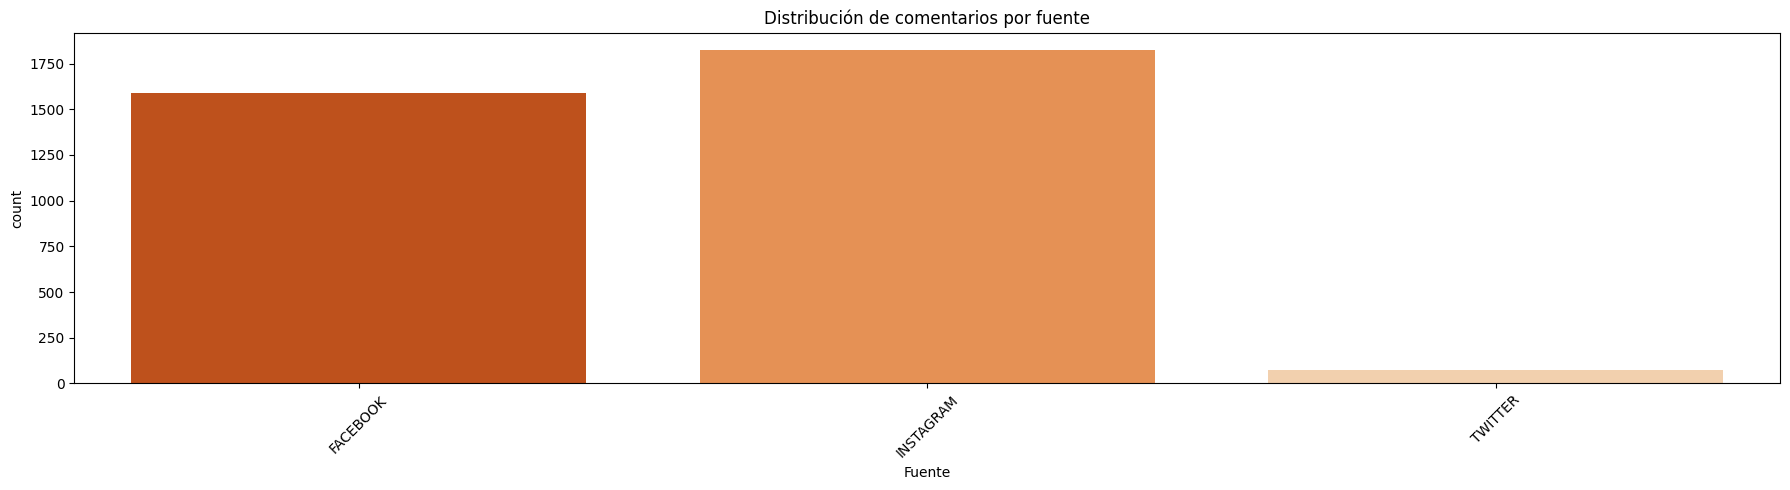

In [42]:
# Calcular la distribución por cantidad
plt.figure(figsize=(18, 5))
sns.countplot(data=df_comentarios_consolidado, x='Fuente', order=['FACEBOOK', 'INSTAGRAM','TWITTER'], palette='Oranges_r')
plt.title('Distribución de comentarios por fuente')
#plt.xlabel('Fuente')
#plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
df_comentarios_consolidado.groupby(['Fuente']).count()['ID']

Fuente
FACEBOOK     1588
INSTAGRAM    1827
TWITTER        75
Name: ID, dtype: int64

In [51]:
df_comentarios_consolidado_2 = df_comentarios_consolidado
df_comentarios_consolidado_2['Año'] = pd.to_datetime(df_comentarios_consolidado_2['Fecha']).dt.year

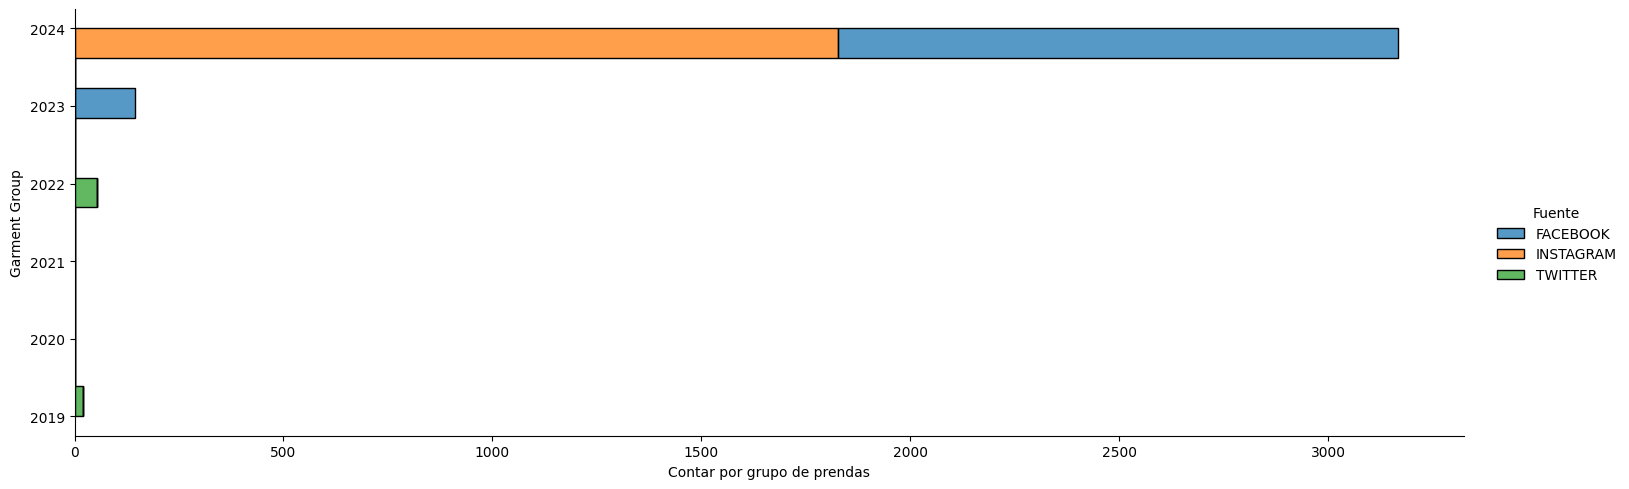

In [55]:
ax = sns.displot(data=df_comentarios_consolidado_2, y='Año', color='orange', hue='Fuente', multiple='stack', aspect=3)
ax.set_axis_labels('Contar por grupo de prendas', 'Garment Group')

In [45]:
df_comentarios_consolidado.sample(10)

,Comentarios,Fuente,Fecha,ID
2890,No tengo señal,INSTAGRAM,2024-08-30,2891
695,"#Misituación estamos a full con la batería,con...",FACEBOOK,2024-11-04,696
1404,#MISITUACIÓN Está excelente porque tenemos a ...,FACEBOOK,2024-11-04,1405
1558,#Misituación esta como el almacenamiento de mi...,FACEBOOK,2024-11-04,1559
828,"#Misituacion si gano , le digo a todos si es v...",FACEBOOK,2024-11-04,829
799,"#Misituacion en proceso de carga, pronto llega...",FACEBOOK,2024-11-04,800
1629,Entel y beonotocias...mi familia!!!🙌,INSTAGRAM,2024-10-03,1630
2077,ES HOOOY ASÍ QUE POR ÚLTIMO #MISITUACIÓN ES CO...,INSTAGRAM,2024-10-22,2078
3337,Que de malo paso acá son seres humanos como to...,INSTAGRAM,2024-06-30,3338
1519,"#Misituación amorosa con la batería en 100%, c...",FACEBOOK,2024-11-04,1520


In [27]:
df_comentarios_consolidado.to_excel('Resultados2.xlsx',index=False)
